# Setup
For the below problems, use the `MNIST_784` data set from OpenML.  Prior to using the data, scale the data and split into a test and training dataset.  The first 60,000 images are available to use as training data, and the remaining 10,000 images as test data.

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#fetch OpenML data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

#split into test/validation/training sets
train_bound = slice(0, 10_000)
val_bound = slice(10_000,20_000)
test_bound = slice(60_000, None)
partition = lambda X, y, slc: (X[slc], y[slc])
X_train, y_train = partition(X, y, train_bound)
X_val, y_val = partition(X, y, val_bound)
X_test, y_test = partition(X, y, test_bound)

## Problem 1: Dimensionality Reduction (30 pts)
Scale the training dataset.  Using principal component analysis (PCA), reduce the dimensionality of the training images to include 75\% of the original variance.  How many components remain following the dimensionality reduction?  Finally, apply the scaling and PCA transformations to the validation and test datasets.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize the training data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Determine the number of components needed for 75% variance
pca_full = PCA().fit(X_train_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.75) + 1  # Find first component reaching 75% variance

# Apply PCA with the determined number of components
pca = PCA(n_components=n_components)
X_train_reduced = pca.fit_transform(X_train_scaled)

# Transform the test set
X_test_scaled = scaler.transform(X_test)
X_test_reduced = pca.transform(X_test_scaled)

print("Number of components remaining after PCA:", n_components)


Number of components remaining after PCA: 33


# Problem 2: Support Vector Machines (50 pts)

Using the dimensionality-reduced dataset from the previous problem, train a support vector machine to classify whether a digit is less than 5 (i.e., $y \in \left\{0, 1, 2, 3, 4\right\}$).  Find a set of hyperparameters, to include the kernel function and $C$, that maximize the $F_1$ score.  The best-performing model should have an $F_1$ score of at least 0.93.

Notes:
* You may want to initially search $C$ over several orders of magnitude.  Consider initially searching with \texttt{np.logspace}.
* The hyperparameter selection may take a long time to run.  If using Google Colab, you may want to save or print the model so the work is not lost if the model reconnects.  See [Scikit-learn documentation](https://scikit-learn.org/stable/modules/model_persistence.html) for details.
* As noted in class, the `LinearSVC` class is more efficient than `SVC(kernel='linear')` for a linear SVC.

In [ ]:
import numpy as np
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Convert labels for binary classification
y_train_binary = (y_train.astype(int) < 5).astype(int)
y_test_binary = (y_test.astype(int) < 5).astype(int)
y_val_binary = (y_val.astype(int) < 5).astype(int)

# Define hyperparameter grids
param_grid_svc = {'svc__C': np.logspace(0, 6, 5), 'svc__kernel': ['poly'], 'svc__gamma': np.logspace(0, 6, 5)}
param_grid_linsvc = {'linearsvc__C': np.logspace(0, 6, 5)}

# Create pipelines for SVC and LinearSVC
pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),  # Standardize before applying SVM
    ('svc', SVC())
])

pipeline_linsvc = Pipeline([
    ('scaler', StandardScaler()),
    ('linearsvc', LinearSVC(dual=False, max_iter=10000))
])

# Perform GridSearchCV for SVC
grid_search_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=5, verbose=3, scoring='f1', n_jobs=-1)
grid_search_svc.fit(X_train_reduced, y_train_binary)

# Perform GridSearchCV for LinearSVC
grid_search_linsvc = GridSearchCV(pipeline_linsvc, param_grid_linsvc, cv=5, verbose=3, scoring='f1', n_jobs=-1)
grid_search_linsvc.fit(X_train_reduced, y_train_binary)

# Store best estimators and their scores
models = {
    "SVC (Poly Kernel)": (grid_search_svc.best_estimator_, grid_search_svc.best_score_),
    "Linear SVC": (grid_search_linsvc.best_estimator_, grid_search_linsvc.best_score_)
}

# Select the best-performing model
best_model_name = max(models, key=lambda x: models[x][1])
best_model = models[best_model_name][0]

# Print results
print(f"Best Model: {best_model_name}")
print("Best Estimator:", best_model)
print("Best Score:", models[best_model_name][1])


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Model: SVC (Poly Kernel)
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVC(gamma=1.0, kernel='poly'))])
Best Score: 0.9546284953860136


# Problem 3: Evaluation (20 pts)
Using the best estimator you found in the previous problem, print the confusion matrix and F1 score.  You may use cross-validation methods (e.g., `cross_val_predict`) or the validation hold-out set for this problem; however, you should not yet use the test data set (last 10,000 records).

In [ ]:
#confusion matrix display function
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
def confusion_matrix_heatmap(cm: np.ndarray, fsize:int=1, fmt:str=",",
                             cmap=None) -> plt.Figure:
  sns.set_theme(font_scale=fsize)
  fig, ax = plt.subplots(figsize=(5,5))
  ConfusionMatrixDisplay(cm).plot(values_format=fmt, cmap=cmap, ax=ax)
  ax.grid(False)
  return fig

Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4869
           1       0.96      0.95      0.95      5131

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



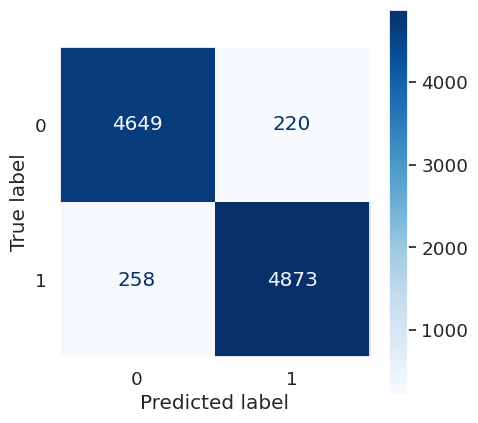

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA on training data (this should already have been done before)
pca = PCA(n_components=33)  # Use the same number of components you used earlier
X_train_reduced = pca.fit_transform(X_train)  # Apply PCA to the training data

# Training Set Evaluation (using cross-validation)
y_prediction_train = cross_val_predict(best_model, X_train_reduced, y_train_binary, cv=3)

# Classification Report and Confusion Matrix for Training Set
print("Training Set Classification Report:")
print(classification_report(y_train_binary, y_prediction_train))

# Compute confusion matrix for training set
cm_train = confusion_matrix(y_train_binary, y_prediction_train)

# Plot confusion matrix for training set using ConfusionMatrixDisplay
sns.set_theme(font_scale=1.2)
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay(confusion_matrix=cm_train).plot(values_format="d", cmap="Blues", ax=ax)
ax.grid(False)
plt.show()




